<a href="https://colab.research.google.com/github/j22-robertson/ESD/blob/master/mushroomcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
# import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms
import tensorflow as tf
from tensorflow import keras


inception = True
rsnet = False

size = 0
resizeto = 0
if inception:
  size = 299
  resizeto = 343
else:
  size = 224
  resizeto = 236


# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available. Training on CPU.')
else:
  print('CUDA is available. Training on GPU.')

CUDA is available. Training on GPU.


In [ ]:
!git clone https://github.com/yiskw713/SmoothGradCAMplusplus.git

Cloning into 'SmoothGradCAMplusplus'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 47 (delta 13), reused 24 (delta 11), pack-reused 20
Receiving objects: 100% (47/47), 3.29 MiB | 8.68 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [ ]:
%cd /content/SmoothGradCAMplusplus/

/content/SmoothGradCAMplusplus


In [ ]:
import cam
from cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp

In [ ]:



import skimage.transform

import torch.nn as nn
import torch.nn. functional as F

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models
from torchvision.utils import save_image


from utils.visualize import visualize, reverse_normalize
from utils.imagenet_labels import label2idx, idx2label

In [ ]:
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [ ]:
!unzip '/content/gdrive/MyDrive/Mushroom_Dataset'

Archive:  /content/gdrive/MyDrive/Mushroom_Dataset.zip
   creating: Dataset/Aleuria aurantia/
  inflating: Dataset/Aleuria aurantia/1.aleuria_aurantia_%28orange_peel_fungus%29.jpg  
  inflating: Dataset/Aleuria aurantia/10.1601553092_aleuria-aurantia-1.jpg  
  inflating: Dataset/Aleuria aurantia/11.69631_small.jpg  
  inflating: Dataset/Aleuria aurantia/12.1280px-aleuria-aurantia.jpg  
  inflating: Dataset/Aleuria aurantia/13.aleuria_aurantia_mgw-08.jpg  
  inflating: Dataset/Aleuria aurantia/14.1000_f_322606549_hs2asd3upnp1t5sozlukebnklma6y3ow.jpg  
  inflating: Dataset/Aleuria aurantia/15.8099320730_eb4c4111c7_b.jpg  
  inflating: Dataset/Aleuria aurantia/16.aleuria-aurantia6.jpg  
  inflating: Dataset/Aleuria aurantia/17.orange-peel-fungi-aleuria-aurantia-6292155.jpg.webp  
  inflating: Dataset/Aleuria aurantia/18.aleuria_aurantia_03.jpg  
  inflating: Dataset/Aleuria aurantia/19.aleuria%20aurantia%204%2c%20grote%20oranje%20bekerzwam%2c%20saxifraga-jan%20de%20laat.jpg  
  inflating:

In [ ]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [ ]:
pip install split-folders

In [ ]:
%cd /content/gdrive/MyDrive

/content/gdrive/MyDrive


In [ ]:
import splitfolders
splitfolders.ratio("Dataset", output="output",
    seed=1337, ratio=(.7, .15, .15), group_prefix=None, move=False)

Copying files: 1811 files [28:58,  1.04 files/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# define batch size
batch_size = 16

# define transforms
# training (with random flips and rotation)
train_transform = transforms.Compose([transforms.Resize(resizeto), # resize to 236x?
                                transforms.RandomRotation(5), # random rotation
                                transforms.CenterCrop(size), # take a square (224x224) crop from the centre
                                transforms.RandomHorizontalFlip(), # randomly flip on horizontal axis
                                transforms.ToTensor(), # convert data to torch.FloatTensor
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])]) # normalise for each colour channel

# validation and testing
transform = transforms.Compose([transforms.Resize(resizeto), # resize to 224x?
                                transforms.CenterCrop(size), # take a square (224x224) crop from the centre
                                transforms.ToTensor(), # convert data to torch.FloatTensor
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])]) # normalise for each colour channel

# choose the training, validation and test datasets
train_data = datasets.ImageFolder("output"+ '/train', transform=train_transform)
val_data = datasets.ImageFolder("output"+ '/val', transform=transform)
test_data = datasets.ImageFolder("output" + '/test', transform=transform)

# prepare the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True,drop_last= True)

val_loader = torch.utils.data.DataLoader(val_data, batch_size, shuffle=True,drop_last = True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True,drop_last = True)



torch.Size([16])


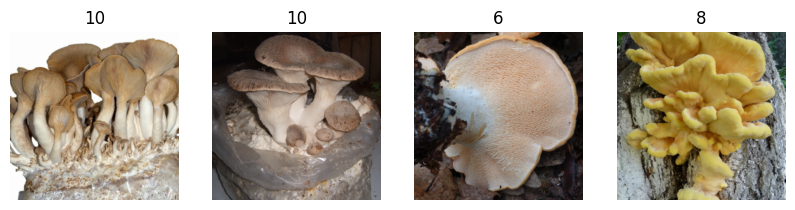

In [ ]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(labels.shape)

# plot the first 4 images in the batch, along with the corresponding labels
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)
    ax.set_title(str(labels[ii].item()))

In [ ]:
#########################################################################
# use a ResNet18 network
# #########################################################################
# NB This network requires an image input size of 3x224x224 and normalised using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].




model = models.inception_v3(pretrained=True)
model.aux_logits = False


#model = models.resnet18(pretrained=True)


# # if we use the following code the pre-trained weights are frozen and we only update the final layer
#for param in model.parameters():
  #param.requires_grad = False

# get the number of inputs for the final layer (fc) of the network
num_ftrs = model.fc.in_features
# replace the final layer so that the output is number of classes
model.fc = nn.Linear(num_ftrs, 15)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()


print(model)

# #########################################################################
# #########################################################################

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
import torch.optim as optim

# specify loss function (cross entropy loss)
criterion = nn.CrossEntropyLoss()
# specify optimizer (Adam optimiser) and learning rate = 0.003
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# number of epochs to train the model
n_epochs = 20

# initialise tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

# create empty lists to store the training and validation losses
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model

        output =  model(data.cuda())

        # calculate the loss
        loss = criterion(output, target.cuda())


        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)

    ######################
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in val_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.cuda())
        # calculate the loss
        loss = criterion(output, target.cuda())
        # update running validation loss
        valid_loss += loss.item()*data.size(0)

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)

    # store the training and validation losses for later visualisation
    train_losses.append(train_loss)
    val_losses.append(valid_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1,
        train_loss,
        valid_loss
        ))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'CNN_model.pt') # save in colab
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/CNN_model.pt') # save in google drive
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.530697 	Validation Loss: 0.375304
Validation loss decreased (inf --> 0.375304).  Saving model ...
Epoch: 2 	Training Loss: 0.419277 	Validation Loss: 0.209017
Validation loss decreased (0.375304 --> 0.209017).  Saving model ...
Epoch: 3 	Training Loss: 0.225114 	Validation Loss: 0.223370
Epoch: 4 	Training Loss: 0.122887 	Validation Loss: 0.182276
Validation loss decreased (0.209017 --> 0.182276).  Saving model ...
Epoch: 5 	Training Loss: 0.101352 	Validation Loss: 0.242561
Epoch: 6 	Training Loss: 0.098448 	Validation Loss: 0.212514
Epoch: 7 	Training Loss: 0.085161 	Validation Loss: 0.226524
Epoch: 8 	Training Loss: 0.054533 	Validation Loss: 0.244829
Epoch: 9 	Training Loss: 0.066947 	Validation Loss: 0.249501
Epoch: 10 	Training Loss: 0.064280 	Validation Loss: 0.307110
Epoch: 11 	Training Loss: 0.071007 	Validation Loss: 0.254460
Epoch: 12 	Training Loss: 0.060106 	Validation Loss: 0.271367
Epoch: 13 	Training Loss: 0.030601 	Validation Loss: 0.161894
V

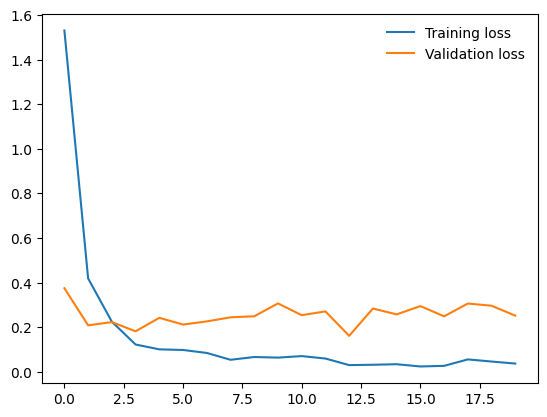

In [ ]:
# Visualise the training and validation losses over time
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

In [ ]:
# Load the Model with the Lowest Validation Loss
model.load_state_dict(torch.load('CNN_model.pt'))

<All keys matched successfully>

In [ ]:
#
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(16))
class_total = list(0. for i in range(16))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data.cuda())
    # calculate the loss
    loss = criterion(output, target.cuda())
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.cuda().data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target.cuda())):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(4):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

RuntimeError: ignored

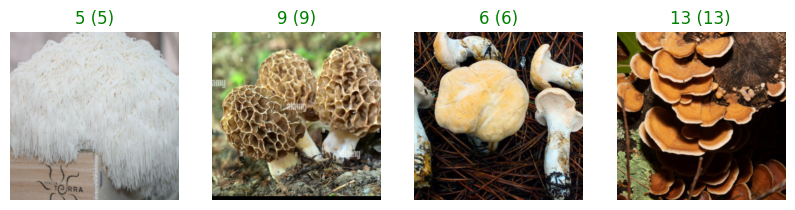

In [ ]:
# obtain one batch of test images
data_iter = iter(test_loader)
images, labels = next(data_iter)
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the first 4 images in the batch, along with the corresponding labels
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images.cpu()[ii], ax=ax, normalize=True)
    ax.set_title("{} ({})".format(str(preds[ii].item()), str(labels[ii].item())),
                 color=("green" if preds[ii]==labels[ii] else "red"))

In [ ]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

In [ ]:
from PIL import Image

In [ ]:
e

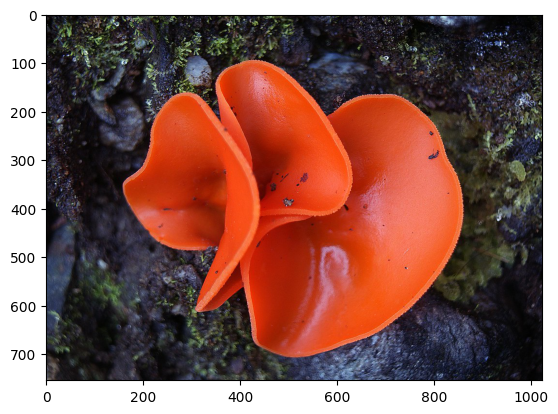

In [ ]:
image = Image.open('/content/gdrive/MyDrive/Dataset/Aleuria aurantia/15.8099320730_eb4c4111c7_b.jpg')
plt.imshow(image)
# convert image to tensor
tensor = preprocess(image)

# reshape 4D tensor (N, C, H, W)
tensor = tensor.unsqueeze(0)

In [ ]:
# Load previously trained model

# create a new model with ResNet18 architecture
#myModel = models.resnet18(pretrained=True)


myModel = models.inception_v3(pretrained=True)
myModel.aux_logits = False
# get the number of inputs for the final layer (fc) of the network
num_ftrs = myModel.fc.in_features
# replace the final layer so that the output is four classes
myModel.fc = nn.Linear(num_ftrs, 15)
# load previously trained model
myModel.load_state_dict(torch.load('/content/gdrive/MyDrive/CNN_model.pt'))

myModel.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: ignored

In [ ]:
# the target layer you want to visualize
#target_layer = myModel.layer4[1].conv2
target_layer = myModel.Mixed_7c.branch3x3dbl_3b
# wrapper for class activation mapping. Choose one of the following.
# wrapped_model = CAM(myModel, target_layer)
# wrapped_model = GradCAM(myModel, target_layer)
# wrapped_model = GradCAMpp(myModel, target_layer)
wrapped_model = SmoothGradCAMpp(myModel, target_layer, n_samples=25, stdev_spread=0.15)

In [ ]:
cam, idx = wrapped_model(tensor)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


predicted class ids 0	 probability 0.7137247920036316


In [ ]:
# visualize only cam


plt.imshow(cam.squeeze().numpy(), alpha=0.5, cmap='jet')
#imshow(cam.numpy(), None, None, True)

#imshow(cam.squeeze().numpy(), alpha=0.5, cmap='jet')

NameError: ignored

In [ ]:
# reverse normalization for display
img = reverse_normalize(tensor)

In [ ]:
heatmap = visualize(img, cam)

In [ ]:
save_image(heatmap, 'smoothgradcampp.png')

<Axes: >

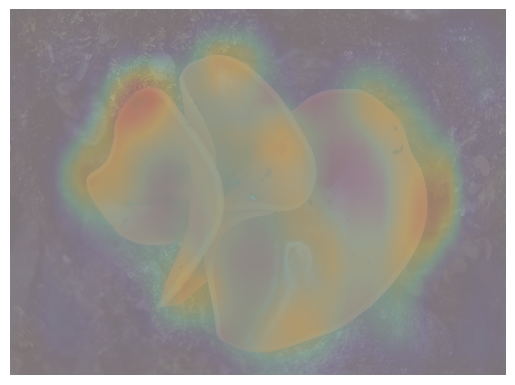

In [ ]:
# or visualize on Jupyter
hm = (heatmap.squeeze(0))
imshow(hm)

In [ ]:
class MyInceptionFeatureExtractor(nn.Module):
    def __init__(self, inception, transform_input=False):
        super(MyInceptionFeatureExtractor, self).__init__()
        self.transform_input = transform_input
        self.Conv2d_1a_3x3 = inception.Conv2d_1a_3x3
        self.Conv2d_2a_3x3 = inception.Conv2d_2a_3x3
        self.Conv2d_2b_3x3 = inception.Conv2d_3a_3x3
        self.Conv2d_3b_1x1 = inception.Conv2d_3b_3x3
        self.Conv2d_4a_3x3 = inception.Conv2d_4a_3x3
        self.Mixed_5b = inception.Mixed_5b
        # stop where you want, copy paste from the model def

    def forward(self, x):
        if self.transform_input:
            x = x.clone()
            x[0] = x[0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x[1] = x[1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x[2] = x[2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        # 299 x 299 x 3
        x = self.Conv2d_1a_3x3(x)
        # 149 x 149 x 32
        x = self.Conv2d_2a_3x3(x)
        # 147 x 147 x 32
        x = self.Conv2d_2b_3x3(x)
        # 147 x 147 x 64
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # 73 x 73 x 64
        x = self.Conv2d_3b_1x1(x)
        # 73 x 73 x 80
        x = self.Conv2d_4a_3x3(x)
        # 71 x 71 x 192
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # 35 x 35 x 192
        x = self.Mixed_5b(x)
        # copy paste from model definition, just stopping where you want
        return x

In [ ]:
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable

# load a pre-trained ResNet network with 18 layersinception = torchvision.models['inception_v3_google']

model =  models.inception_v3(pretrained=True)

myModel.fc = nn.Linear(num_ftrs, 15)
#model = MyInceptionFeatureExtractor(model)
#model.fc = nn.Identity()
#
# # remove the final layer so the output of the network is now a 512 feature vector

#model_feature_extractor = torch.nn.Sequential(*(list(model.modules())[:-2]))
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

model.eval()


print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
# Load previously trained model

# create a new model with ResNet18 architecture
#myModel = models.resnet18(pretrained=True)
myModel = models.inception_v3(pretrained=True)


# get the number of inputs for the final layer (fc) of the network
num_ftrs = myModel.fc.in_features

myModel.fc = nn.Linear(num_ftrs, 15)

# load previously trained model

myModel.load_state_dict(torch.load('/content/gdrive/MyDrive/CNN_model.pt'))

#myModel = MyInceptionFeatureExtractor(myModel)
#mushroom_feature_extractor = torch.nn.Sequential(*(list(model.modules())[:-2]))

#
#myModel = nn.Sequential(*list(myModel.children())[:-2])

# move tensors to GPU if CUDA is available
if train_on_gpu:
    myModel.cuda()

myModel.eval()

print(myModel)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
# Visualize Sample Test Results
# define batch size
batch_size = 20

# define transforms
# training (with random flips and rotation)

transform = transforms.Compose([transforms.Resize(resizeto), # resize to 224x?
                                transforms.CenterCrop(size), # take a square (224x224) crop from the centre
                                transforms.ToTensor(), # convert data to torch.FloatTensor
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])])
# choose the training, validation and test datasets
test_data = datasets.ImageFolder("output" + '/test', transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True,drop_last = True)
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)


images.numpy()


print(images.shape)
# move model inputs to cuda, if GPU available
if train_on_gpu:
   images = images.cuda()

print(images.shape)
# get sample outputs
mushroom_feats = myModel(images)
imageNet_feats = model(images)

# put on cpu, convert to numpy array and squeeze to batchsize x 512
imageNet_feats = np.squeeze(imageNet_feats.cpu().detach().numpy())
mushroom_feats = np.squeeze(mushroom_feats.cpu().detach().numpy())

labels = labels.numpy()

print(imageNet_feats.shape)
print(mushroom_feats.shape)
print(labels)

torch.Size([20, 3, 299, 299])
torch.Size([20, 3, 299, 299])
(20, 1000)
(20, 15)
[ 9 10  7  6  0  8 14 14  4  4  3  6  3 14  7 14  7 10  4  8]


<ipython-input-30-c6d03d89066f>:77: UserWarning: Legend does not support handles for int instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend((class0, class1, class2, class3, class4, class5, class6, class7, class8, class9, class10, class11, class12, class13, class14), ('0: Aleuria aurantia','1: Amanita muscaria','2: Auricularia auricula-judae','3: Cortinarius rubellus','4: Fistulina hepatica','5: Hericium erinaceus','6: Hydnum repandum','7: Lacrymaria lacrymabunda','8: Laetiporus sulphureus','9: Morchella esculenta','10: Pleurotus ostreatus','11: Psilocybe semilanceata','12: Sarcoscypha austriaca','13: Trametes versicolor','14: Tuber aestivum'))
<ipython-input-30-c6d03d89066f>:128: UserWarning: Legend does not support handles for int instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-leg

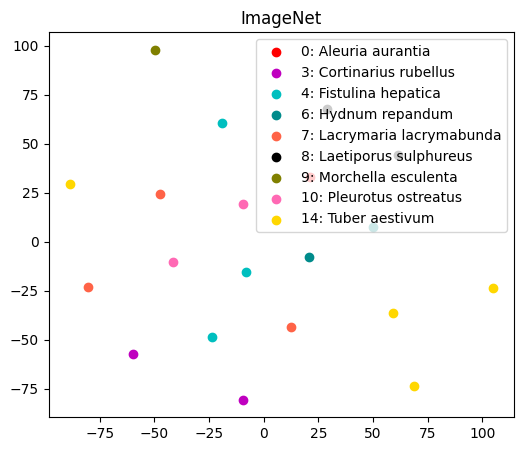

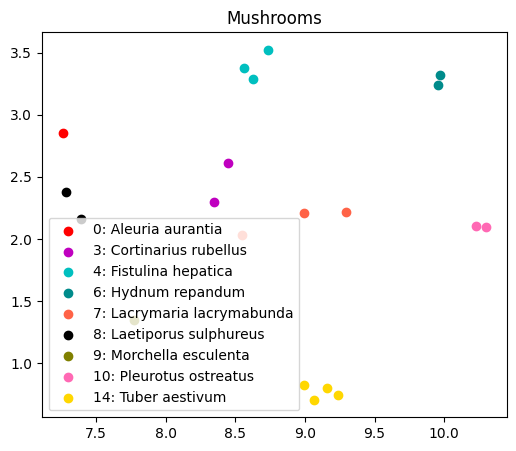

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=1,perplexity=15)

############################################################
# Project the data in 2D
imageNet_X_2d = tsne.fit_transform(imageNet_feats)
mushroom_X_2d = tsne.fit_transform(mushroom_feats)

############################################################
#'0: Aleuria aurantia','1: Amanita muscaria','2: Auricularia auricula-judae','3: Cortinarius rubellus','4: Fistulina hepatica','5: Hericium erinaceus','6: Hydnum repandum','7: Lacrymaria lacrymabunda','8: Laetiporus sulphureus','9: Morchella esculenta','10: Pleurotus ostreatus','11: Psilocybe semilanceata','12: Sarcoscypha austriaca','13: Trametes versicolor','14: Tuber aestivum'
# Visualize the data
class0 = 1
class1 = 1
class2 = 1
class3= 1
class4= 1
class5= 1
class6= 1
class7= 1
class8= 1
class9= 1
class10= 1
class11= 1
class12= 1
class13= 1
class14= 1

plt.figure(figsize=(6, 5))
for i in range(imageNet_X_2d.shape[0]):
  if labels[i] == 0:
    # 0 is Aleuria aurantia
    class0 = plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='r')
  if labels[i] == 1:
    #1 is Amanita muscaria
    class1 = plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='g')
  if labels[i] == 2:
    # 2 is Auricularia auricula-judae
    class2 = plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='b')
  if labels[i] == 3:
    # 3 is Cortinarius rubellus
    class3 = plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='m')
  if labels[i] == 4:
    # 4 is Fistulina hepatica
    class4 = plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='c')
  if labels[i] == 5:
    # 5 is Hericium erinaceus
    class5 = plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='orchid')
  if labels[i] == 6:
    # 6 is Hydnum repandum
    class6 = plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='darkcyan')
  if labels[i] == 7:
    # 7 is Lacrymaria lacrymabunda
    class7 = plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='tomato')
  if labels[i] == 8:
    # 8 is Laetiporus sulphureus
    class8 = plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='k')
  if labels[i] == 9:
    # 9 is Morchella esculenta
    class9 = plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='olive')
  if labels[i] == 10:
    # 10 is Pleurotus ostreatus
    class10 = plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='hotpink')
  if labels[i] == 11:
    # 11 is Psilocybe semilanceata
    class11 = plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='pink')
  if labels[i] == 12:
    # 12 is Sarcoscypha austriaca
    class12 = plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='cornflowerblue')
  if labels[i] == 13:
    # 13 is Trametes veriscolor
    class13 = plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='lawngreen')
  if labels[i] == 14:
    # 14 is Tuber Aestivum
    class14 = plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='gold')

plt.title('ImageNet')
plt.legend((class0, class1, class2, class3, class4, class5, class6, class7, class8, class9, class10, class11, class12, class13, class14), ('0: Aleuria aurantia','1: Amanita muscaria','2: Auricularia auricula-judae','3: Cortinarius rubellus','4: Fistulina hepatica','5: Hericium erinaceus','6: Hydnum repandum','7: Lacrymaria lacrymabunda','8: Laetiporus sulphureus','9: Morchella esculenta','10: Pleurotus ostreatus','11: Psilocybe semilanceata','12: Sarcoscypha austriaca','13: Trametes versicolor','14: Tuber aestivum'))

# Visualize the data
plt.figure(figsize=(6, 5))
for i in range(mushroom_X_2d.shape[0]):
  if labels[i] == 0:
    # 0 is Aleuria aurantia
    class0 = plt.scatter(mushroom_X_2d[i,0], mushroom_X_2d[i, 1], c='r')
  if labels[i] == 1:
    #1 is Amanita muscaria
    class1 = plt.scatter(mushroom_X_2d[i,0], mushroom_X_2d[i, 1], c='g')
  if labels[i] == 2:
    # 2 is Auricularia auricula-judae
    class2 = plt.scatter(mushroom_X_2d[i,0], mushroom_X_2d[i, 1], c='b')
  if labels[i] == 3:
    # 3 is Cortinarius rubellus
    class3 = plt.scatter(mushroom_X_2d[i,0], mushroom_X_2d[i, 1], c='m')
  if labels[i] == 4:
    class4 = plt.scatter(mushroom_X_2d[i,0], mushroom_X_2d[i, 1], c='c')
    # 4 is Fistulina hepatica
  if labels[i] == 5:
    # 5 is Hericium erinaceus
    class5 = plt.scatter(mushroom_X_2d[i,0],mushroom_X_2d[i, 1], c='orchid')
  if labels[i] == 6:
    # 6 is Hydnum repandum
    class6 = plt.scatter(mushroom_X_2d[i,0], mushroom_X_2d[i, 1], c='darkcyan')
  if labels[i] == 7:
    # 7 is Lacrymaria lacrymabunda
    class7 = plt.scatter(mushroom_X_2d[i,0], mushroom_X_2d[i, 1], c='tomato')
  if labels[i] == 8:
    # 8 is Laetiporus sulphureus
    class8 = plt.scatter(mushroom_X_2d[i,0], mushroom_X_2d[i, 1], c='k')
  if labels[i] == 9:
    # 9 is Morchella esculenta
    class9 = plt.scatter(mushroom_X_2d[i,0], mushroom_X_2d[i, 1], c='olive')
  if labels[i] == 10:
    # 10 is Pleurotus ostreatus
    class10 = plt.scatter(mushroom_X_2d[i,0], mushroom_X_2d[i, 1], c='hotpink')
  if labels[i] == 11:
    # 11 is Psilocybe semilanceata
    class11 = plt.scatter(mushroom_X_2d[i,0], mushroom_X_2d[i, 1], c='pink')
  if labels[i] == 12:
    # 12 is Sarcoscypha austriaca
    class12 = plt.scatter(mushroom_X_2d[i,0], mushroom_X_2d[i, 1], c='cornflowerblue')
  if labels[i] == 13:
    # 13 is Trametes veriscolor
    class13 = plt.scatter(mushroom_X_2d[i,0], mushroom_X_2d[i, 1], c='lawngreen')
  if labels[i] == 14:
    # 14 is Tuber Aestivum
    class14 = plt.scatter(mushroom_X_2d[i,0], mushroom_X_2d[i, 1], c='gold')
plt.title('Mushrooms')
plt.legend((class0, class1, class2, class3, class4, class5, class6, class7, class8, class9, class10, class11, class12, class13, class14), ('0: Aleuria aurantia','1: Amanita muscaria','2: Auricularia auricula-judae','3: Cortinarius rubellus','4: Fistulina hepatica','5: Hericium erinaceus','6: Hydnum repandum','7: Lacrymaria lacrymabunda','8: Laetiporus sulphureus','9: Morchella esculenta','10: Pleurotus ostreatus','11: Psilocybe semilanceata','12: Sarcoscypha austriaca','13: Trametes versicolor','14: Tuber aestivum'))
plt.show()
